# What is GMM(Gaussian Mixture Model)

The Gaussian Mixture Model (GMM) is an unsupervised learning algorithm that aims to find multiple Gaussian distributions within a dataset. Here's a step-by-step breakdown:

1. Initialization:
Decide the number of Gaussian distributions (components), k.
Initialize means, covariances, and mixture weights. This can be done randomly or using some other technique like the output of a K-means clustering.

2. Expectation (E-step):
For each data point and for each Gaussian distribution, compute the posterior probability that this data point belongs to this Gaussian. These are your "soft" assignments as opposed to K-means which has "hard" assignments.

3. Maximization (M-step):
Update the means, covariances, and mixture weights based on the posterior probabilities computed in the E-step.

4. Convergence Check:
Compute the log-likelihood of the data given the parameters. If this changes very little between iterations, the EM has converged.

5. Repeat E and M steps until the convergence criterion is met.

In [1]:
import cv2 as cv
image_path = './panda.jpg'
image = cv.imread(image_path)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Convert to RGB for proper display using matplotlib
image_rgb.shape
image_pixels = image.reshape((-1,3))
image_pixels.shape

(200170, 3)

In [15]:
import numpy as np
import cv2 as cv
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [25]:
class GMM:
    def __init__(self, ncomp,initial_means, initial_covs, initial_mw):
        self.ncomp = ncomp
        self.means = np.asarray(initial_means)
        self.covs = np.asarray(initial_covs)
        self.mw = np.asarray(initial_mw)
    
    def inference(self, datas): # E-step
        unnormalized_probs = []
        for i in range(self.ncomp):
            means, cov, mw = self.means[i, :], self.covs[i, :, :], self.mw[i]
            unnormalized_prob = mw * multivariate_normal.pdf(datas, mean=means, cov=cov)
            # Why this? Even I have different dim's possibility density function, you must still calculate the different ncomp's
            # pdf outcome such that we can gauge it as a metric
            unnormalized_probs.append(np.expand_dims(unnormalized_prob, -1))
        preds = np.concatenate(unnormalized_probs, axis=1)
        log_likelihood = np.sum(preds, axis=1) # Caculating the row?
        log_likelihood = np.sum(np.log(log_likelihood))
        
        preds = preds / np.sum(preds, axis=1, keepdims=True)
        return np.asarray(preds), log_likelihood
    
    def update(self, datas, beliefs): # M-step
        new_means, new_covs, new_mw = [], [], []
        soft_counts = np.sum(beliefs, axis=0)
        for i in range(self.ncomp):
            new_mean = np.sum(np.expand_dims(beliefs[:, i], -1) * datas, axis=0)
            new_mean /= soft_counts[i]
            new_means.append(new_mean)
            
            data_shifted = np.subtract(datas, np.expand_dims(new_mean, 0))
            new_cov = np.matmul(np.transpose(np.multiply(np.expand_dims(beliefs[:, i], -1), data_shifted)),data_shifted)
            new_cov /= soft_counts[i]
            new_covs.append(new_cov)
            new_mw.append(soft_counts[i] / np.sum(soft_counts))
            
        self.new_means = np.asarray(new_means)
        self.covs = np.asarray(new_covs)
        self.new_mw = np.asarray(new_mw)
                                                         

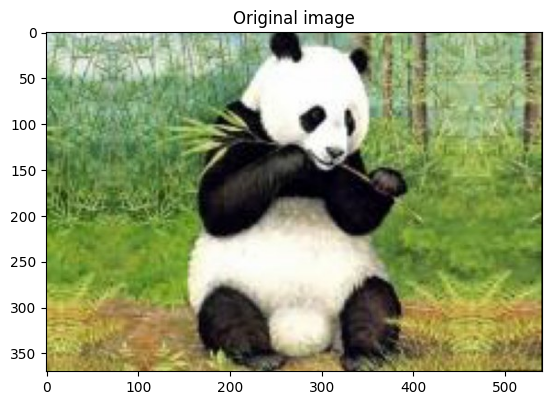

In [3]:
# Load image
img = cv.imread("./panda.jpg")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert to RGB for proper display using matplotlib
plt.imshow(img_rgb)
plt.title('Original image')
plt.show()

In [18]:
img_height, img_width, img_channels = img.shape
img_height , img_width 

(370, 541)

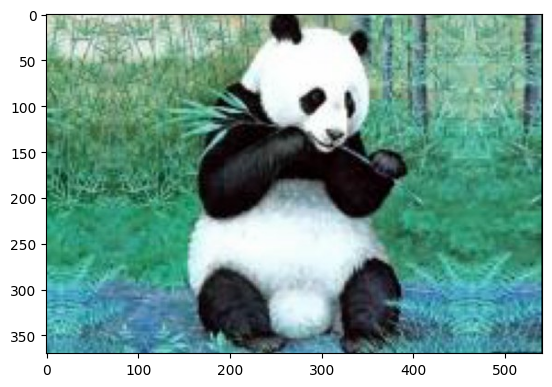

In [19]:
img_pixels = np.reshape(img, (-1, img_channels))
_mean = np.mean(img_pixels, axis=0, keepdims = True)
_std = np.std(img_pixels, axis=0, keepdims = True)
img_pixels = (img_pixels - _mean) / _std # Normalization
img_pixels.shape    # Load image
image_name = 'panda'
image_path = './{}.jpg'.format(image_name)
image = cv.imread(image_path)
plt.imshow(image)
plt.show()

image_height, image_width, image_channels = image.shape
image_pixels = np.reshape(image, (-1, image_channels))
_mean = np.mean(image_pixels,axis=0,keepdims=True)
_std = np.std(image_pixels,axis=0,keepdims=True)
image_pixels = (image_pixels - _mean) / _std # Normalization


In [20]:
# Input number of classes
ncomp = 4

In [21]:
# Apply K-means to find the initial weights and covariance matrices for GMM
kmeans = KMeans(n_clusters = ncomp)
labels = kmeans.fit_predict(image_pixels)
labels, image_pixels.shape

C:\Users\pym66\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([1, 3, 3, ..., 2, 2, 0]), (200170, 3))

In [22]:
initial_means = kmeans.cluster_centers_
initial_mw, initial_covs = [],[]
map_beliefs = np.reshape(labels, (img_height, img_width))
segmented_map = np.zeros((img_height,img_width, 3))
np.max(map_beliefs)

3

In [23]:
colors = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0)
]
len(colors)

4

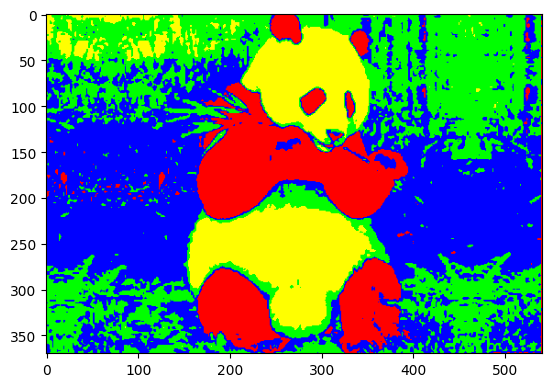

In [24]:
for i in range(img_height):
    for j in range(img_width):
        hard_belief = map_beliefs[i,j]
        segmented_map[i, j, :] = np.asarray(colors[hard_belief]) / 255.0
        
    segmented_map[i, j, :] = np.asarray(colors[hard_belief]) / 255.0
plt.imshow(segmented_map)
plt.show()

In [12]:
for i in range(ncomp):
    datas = np.array([image_pixels[j, :] for j in range(len(labels)) if labels[j] == i]).T
    initial_covs.append(np.cov(datas))
    initial_mw.append(datas.shape[1] / float(len(labels)))
len(initial_covs)

8

In [16]:
# Initializing a GMM
gmm = GMM(ncomp, initial_means, initial_covs, initial_mw)

In [17]:
# EM algorithm
prev_log_likelihood = None
for i in range(1000):
    beliefs, log_likelihood = gmm.inference(image_pixels) # E-step
    gmm.update(image_pixels, beliefs) # M-step
    print('Iteration {}: Log Likelihood = {}'.format(i+1, log_likelihood))
    if prev_log_likelihood != None and abs(log_likelihood - prev_log_likelihood) < 1e-10:
        break
    prev_log_likelihood = log_likelihood


Iteration 1: Log Likelihood = -275036.859391814
Iteration 2: Log Likelihood = -265771.7954064795
Iteration 3: Log Likelihood = -262213.8890917687
Iteration 4: Log Likelihood = -260285.37939447738
Iteration 5: Log Likelihood = -259412.59875389969
Iteration 6: Log Likelihood = -259368.0595951454
Iteration 7: Log Likelihood = -259706.57382314344
Iteration 8: Log Likelihood = -260108.55461931461
Iteration 9: Log Likelihood = -260455.6397823401
Iteration 10: Log Likelihood = -260727.8709216425
Iteration 11: Log Likelihood = -260935.98250218996
Iteration 12: Log Likelihood = -261095.16321204155
Iteration 13: Log Likelihood = -261217.98214449213
Iteration 14: Log Likelihood = -261313.6334220685
Iteration 15: Log Likelihood = -261388.67050813412
Iteration 16: Log Likelihood = -261447.81625788394
Iteration 17: Log Likelihood = -261494.55703352415
Iteration 18: Log Likelihood = -261531.53172739598
Iteration 19: Log Likelihood = -261560.77924128372
Iteration 20: Log Likelihood = -261583.897957807

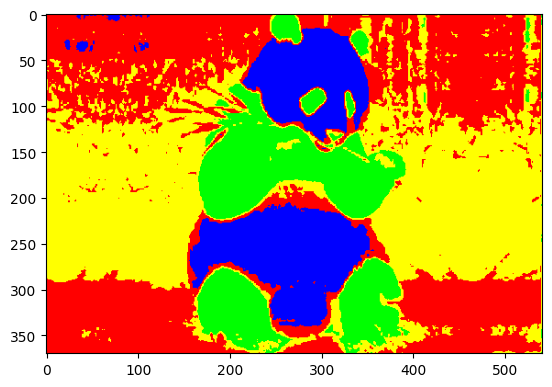

In [185]:
# Show result
beliefs, log_likelihood = gmm.inference(image_pixels)
map_beliefs = np.reshape(beliefs, (image_height, image_width, ncomp))
segmented_map = np.zeros((image_height, image_width, 3))
for i in range(image_height):
    for j in range(image_width):
        hard_belief = np.argmax(map_beliefs[i, j, :])
        segmented_map[i,j,:] = np.asarray(colors[hard_belief]) / 255.0
plt.imshow(segmented_map)
plt.show()